In [27]:
#we import the libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator

Ex 2

In [28]:
#definition of acceleration function, in order to solve the differential equations
def acceleration(r, v, A, B, M_BH, G):
    r_norm = np.linalg.norm(r)
    a_grav = -G * M_BH * r / (4*r_norm**3)
    v_norm = np.linalg.norm(v)
    if v_norm > 1e-12:
        a_df = -A * v / (v_norm**3 + B )
    else:
        a_df = np.array([0.0, 0.0])
    return a_grav + a_df

#definition of the ringe kutta fourth order method
def rk4_step(r, v, dt, A, B, M_BH, G):
    k1_r = v
    k1_v = acceleration(r, v, A, B, M_BH, G)
    
    k2_r = v + 0.5*dt*k1_v
    k2_v = acceleration(r + 0.5*dt*k1_r, v + 0.5*dt*k1_v, A, B, M_BH, G)
    
    k3_r = v + 0.5*dt*k2_v
    k3_v = acceleration(r + 0.5*dt*k2_r, v + 0.5*dt*k2_v, A, B, M_BH, G)
    
    k4_r = v + dt*k3_v
    k4_v = acceleration(r + dt*k3_r, v + dt*k3_v, A, B, M_BH, G)
    
    r_next = r + dt/6 * (k1_r + 2*k2_r + 2*k3_r + k4_r)
    v_next = v + dt/6 * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    
    return r_next, v_next

In [29]:
# -----------------------------
# Parameters important for all the code
# -----------------------------
G = 1.0         # Gravitational constant
M_BH = 1.0      # Mass of the black hole
r_per = 1e-7    # Target pericenter

# No dynamical friction for this part
A = 0.0
B = 0.0

# Initial conditions
r = np.array([1.0, 0.0])
v_circ = np.sqrt(G * M_BH / 4)

v = np.array([0.0, 0.00046*v_circ]) 

period = 2 * np.pi / v_circ

# Time parameters
t0 = 0.0
#t_end = 10.0 
t_end = 50.0    # this is the time in order to have at least 10 orbits      
dt = 1e-8       # Initial timestep
delta = 1e-7   # Desired relative accuracy

# History arrays
r_hist = []
v_hist = []
t_hist = []

while True:
    # Single full step
    r1, v1 = rk4_step(r, v, dt, A, B, M_BH, G)
    
    # Two half-steps
    r_half, v_half = rk4_step(r, v, dt/2, A, B, M_BH, G)
    r2, v2 = rk4_step(r_half, v_half, dt/2, A, B, M_BH, G)
    
    rho = 30 * delta * dt / (np.linalg.norm(r2 - r1) + 1e-40)

    if rho > 1.0:
        r, v = r2, v2
        t0 += dt
        r_hist.append(r.copy())
        v_hist.append(v.copy())
        t_hist.append(t0)
        #increase dt
        dt *= min(1.5, rho**0.25)
    else:
        # reject step and reduce dt
        dt *= max(0.5, rho**0.25)
    
    # Stop when the time choosen is reached
    if t0 >= t_end:
        print(f"Stopped at t = {t0:.3e}, r = {np.linalg.norm(r):.3e}")
        break

# Convert history to arrays
r_hist = np.array(r_hist)
v_hist = np.array(v_hist)
t_hist = np.array(t_hist)


Stopped at t = 5.004e+01, r = 9.162e-01


In [30]:
#value of the initial velocity 
print(f"Value of the initial velocity: {0.00046*v_circ}")

Value of the initial velocity: 0.00023


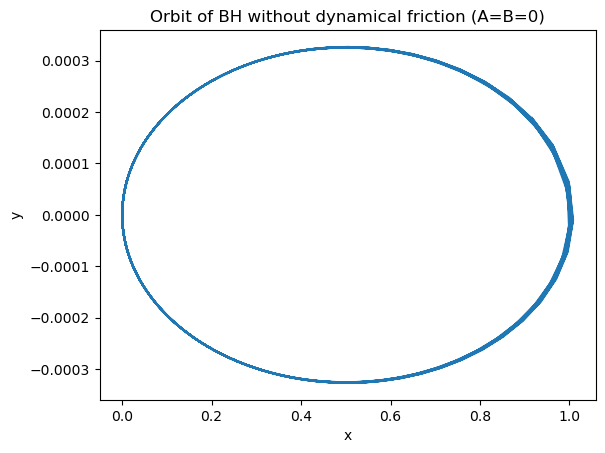

Minimum radius (pericenter) reached: 1.0579999392716892e-07


In [31]:
# Plot orbit
#plt.figure(figsize=(6,6))
plt.plot(r_hist[:,0], r_hist[:,1])
#plt.plot(0,0,'ro',label='BH center')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of BH without dynamical friction (A=B=0)')
#plt.legend()
plt.show()

# Minimum radius reached
r_min = np.min(np.linalg.norm(r_hist, axis=1))
print("Minimum radius (pericenter) reached:", r_min)

Max relative $\Delta E$ = 0.0021464234492296493


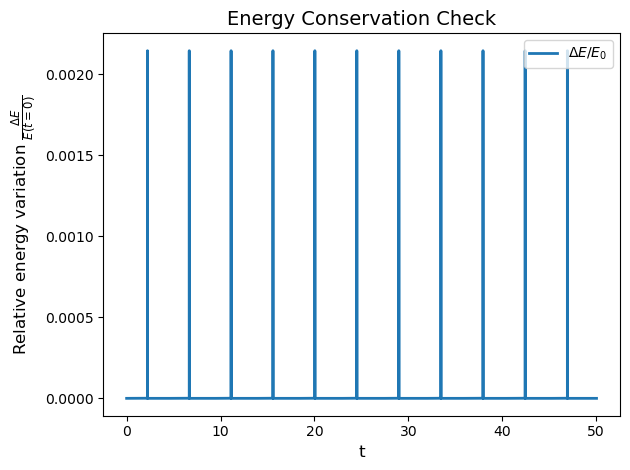

In [32]:
#we now plot the error to prove that we have more or less the same 

#we can compute the energy 
energies = np.zeros(len(t_hist))
v_mod = np.linalg.norm(v_hist, axis=1)


kinetic = 0.5 * np.dot(v_mod, v_mod)       
potential = -G * M_BH / (np.linalg.norm(r_hist, axis=1)+1e-30)  # -GM/r #we have added a small number to avoid division by zero
energies = kinetic + potential

#we print some useful statistics
deltaE = abs(energies - energies[0])
relE = deltaE / (abs(energies[0]))
print("Max relative $\Delta E$ =", np.max(np.abs(relE)))


# -----------------------------
# Relative energy variation plot
plt.plot(t_hist, relE, linewidth=2, label=r'$\Delta E / E_0$')

# Labels and title
plt.xlabel('t', fontsize=12)
plt.ylabel(r'Relative energy variation $\frac{\Delta E}{E(t=0)}$', fontsize=12)
plt.title('Energy Conservation Check', fontsize=14)

# Grid and legend
#plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()




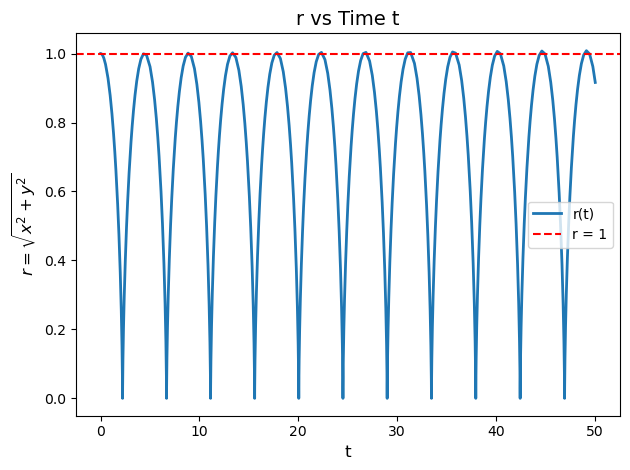

In [33]:
# -----------------------------
# Compute radii
radii = np.linalg.norm(r_hist, axis=1)

# -----------------------------
# Plot: radius vs time
plt.plot(t_hist, radii, linewidth=2, label='r(t)')

# Highlight the initial radius
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='r = 1')

# Labels and title
plt.xlabel('t', fontsize=12)
plt.ylabel('$r = \sqrt{x^2 + y^2}$', fontsize=12)
plt.title('r vs Time t', fontsize=14)

# Grid and style
#plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
    

In [34]:
#we define the function to compute the orbits
def orbits(A , B, v, r_per, max_steps, min_dt, delta, G, M_BH, r, dt, t0):
    r_hist = []
    v_hist = []
    t_hist = []

    step = 0
    while np.linalg.norm(r) > r_per and step < max_steps:
        # Full step
        r1, v1 = rk4_step(r, v, dt, A, B, M_BH, G)
        # Two half steps
        r_half, v_half = rk4_step(r, v, dt/2, A, B, M_BH, G)
        r2, v2 = rk4_step(r_half, v_half, dt/2, A, B, M_BH, G)

        # RK4 adaptive step (LTE)
        rho = 30 * delta * dt / (np.linalg.norm(r2 - r1)+1e-40)

        if rho >= 1.0:
            # Accept step
            r, v = r2, v2
            t0 += dt
            r_hist.append(r.copy())
            v_hist.append(v.copy())
            t_hist.append(t0)
            # Increase timestep safely
            dt *= min(1.5, rho**0.25)
        else:
            # Reject step, reduce timestep
            dt *= max(0.5, rho**0.25)

        if dt < min_dt:
            print("Warning: dt too small, stopping")
            break

        step += 1

    r_hist = np.array(r_hist)
    v_hist = np.array(v_hist)
    t_hist = np.array(t_hist)

    return r_hist, v_hist, t_hist, t0, step

In [35]:
#-----------------------------
# NOW WITH DYNAMICAL FRICTION
#-----------------------------

A = 1.0
B = 1.0

# -----------------------------
# PARAMETERS
G = 1.0
M_BH = 1.0
r_per = 1e-7  # Target pericenter

# -----------------------------
# INITIAL CONDITIONS
r = np.array([1.0, 0.0])
v_circ = np.sqrt(G * M_BH / 4)
v = np.array([0.0, 0.8 * v_circ])  # 0.8 circular velocity
#-----------------------------
# INTEGRATION PARAMETERS
t0 = 0.0
dt = 1e-8           # Small initial timestep
delta = 1e-7       # Desired local relative error
min_dt = 1e-18
max_steps = int(1e7)

r_hist, v_hist, t_hist, t_fin, step = orbits(A , B, v, r_per, max_steps, min_dt, delta, G, M_BH, r, dt , t0) 

r_vector = np.linalg.norm(r_hist, axis=1)
print(f"Stopped at t = {t_fin:.3e}, r = {r_vector[-2]:.3e}, steps = {step}")


Stopped at t = 1.076e+01, r = 1.001e-07, steps = 31566


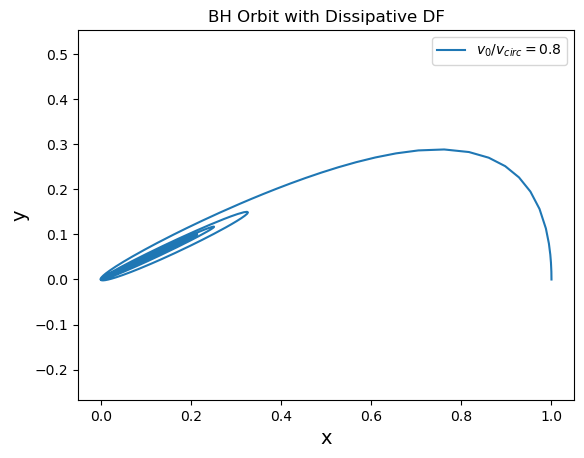

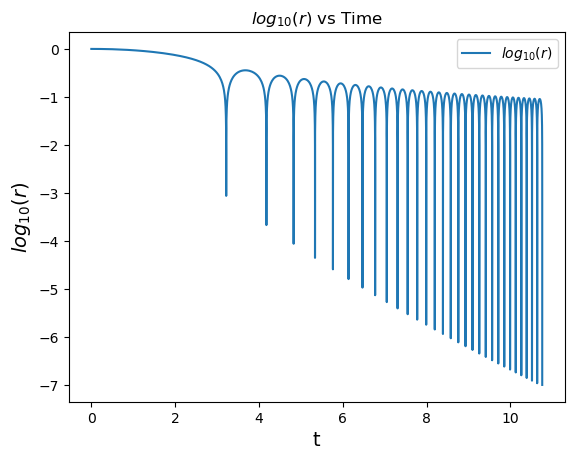

In [36]:
# -----------------------------
# PLOT ORBIT
plt.plot(r_hist[:,0], r_hist[:,1], label='$v_0/v_{circ}  = 0.8$')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.axis('equal')
plt.title('BH Orbit with Dissipative DF')
plt.legend()
plt.show()

# -----------------------------
# PLOT log(r) vs t
r_norms = np.linalg.norm(r_hist, axis=1)
plt.figure()
plt.plot(t_hist, np.log10(r_norms), label='$log_{10}(r)$')
plt.xlabel('t',fontsize=14)
plt.ylabel('$log_{10}(r)$', fontsize=14)
plt.title('$log_{10}(r)$ vs Time')
plt.legend()
plt.show()


In [37]:
# -----------------------------
# PARAMETERS
A = 1.0
B = 1.0
G = 1.0
M_BH = 1.0
r_per = 1e-7  # Target pericenter

# -----------------------------
# INITIAL CONDITIONS
r0 = np.array([1.0, 0.0])
v_circ = np.sqrt(G * M_BH / 4)

# Range of initial velocity factors (fractions of circular velocity)
v_factors = np.linspace(0.6, 1.3, 8)  # 8 values from 0.6*v_circ to 1.3*v_circ

# -----------------------------
# INTEGRATION PARAMETERS
t0 = 0.0
dt = 1e-8
delta = 1e-7
min_dt = 1e-18
max_steps = int(1e7)

# -----------------------------
# Arrays to store results
r_hist_list = []
v_hist_list = []
t_hist_list = []
r_final_list = []
t_final_list = []
steps_list = []
v_init_list = []

# -----------------------------
# LOOP OVER DIFFERENT INITIAL VELOCITIES
for f in v_factors:
    v0 = np.array([0.0, f * v_circ])
    print(f"\nRunning simulation with v0 = {f:.2f} * v_circ = {f*v_circ:.3e}")
    
    r_hist, v_hist, t_hist, t_fin, step = orbits(
        A, B, v0, r_per, max_steps, min_dt, delta, G, M_BH, r0, dt, t0
    )

    # Store results
    r_hist_list.append(r_hist)
    v_hist_list.append(v_hist)
    t_hist_list.append(t_hist)
    r_final_list.append(np.linalg.norm(r_hist[-2]))
    t_final_list.append(t_fin)
    steps_list.append(step)
    v_init_list.append(f * v_circ)

    print(f"  → Stopped at t = {t_fin:.3e}, r = {np.linalg.norm(r_hist[-2]):.3e}, steps = {step}")



Running simulation with v0 = 0.60 * v_circ = 3.000e-01
  → Stopped at t = 1.025e+01, r = 1.000e-07, steps = 28635

Running simulation with v0 = 0.70 * v_circ = 3.500e-01
  → Stopped at t = 1.056e+01, r = 1.002e-07, steps = 30707

Running simulation with v0 = 0.80 * v_circ = 4.000e-01
  → Stopped at t = 1.076e+01, r = 1.001e-07, steps = 31566

Running simulation with v0 = 0.90 * v_circ = 4.500e-01
  → Stopped at t = 1.096e+01, r = 1.004e-07, steps = 32657

Running simulation with v0 = 1.00 * v_circ = 5.000e-01
  → Stopped at t = 1.107e+01, r = 1.003e-07, steps = 32577

Running simulation with v0 = 1.10 * v_circ = 5.500e-01
  → Stopped at t = 1.119e+01, r = 1.006e-07, steps = 32634

Running simulation with v0 = 1.20 * v_circ = 6.000e-01
  → Stopped at t = 1.122e+01, r = 1.002e-07, steps = 31583

Running simulation with v0 = 1.30 * v_circ = 6.500e-01
  → Stopped at t = 1.127e+01, r = 1.006e-07, steps = 30744


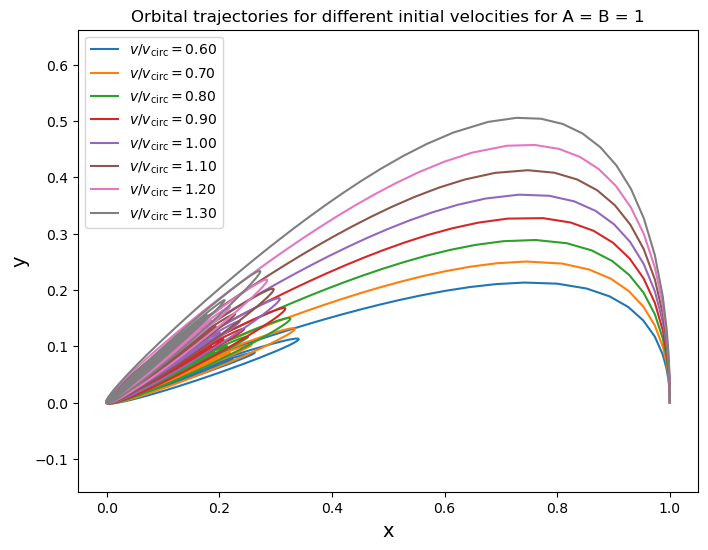

In [ ]:
plt.figure(figsize=(8,6))

for i, f in enumerate(v_factors):
    r_hist = np.array(r_hist_list[i])   # convert to NumPy array for indexing
    x = r_hist[:,0]
    y = r_hist[:,1]
    plt.plot(x, y, label=fr'$v / v_{{\rm circ}} = {f:.2f}$')

# Aesthetics
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Orbital trajectories for different initial velocities for A = B = 1')
plt.legend()
plt.axis('equal')  # equal scaling for x and y 
#plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


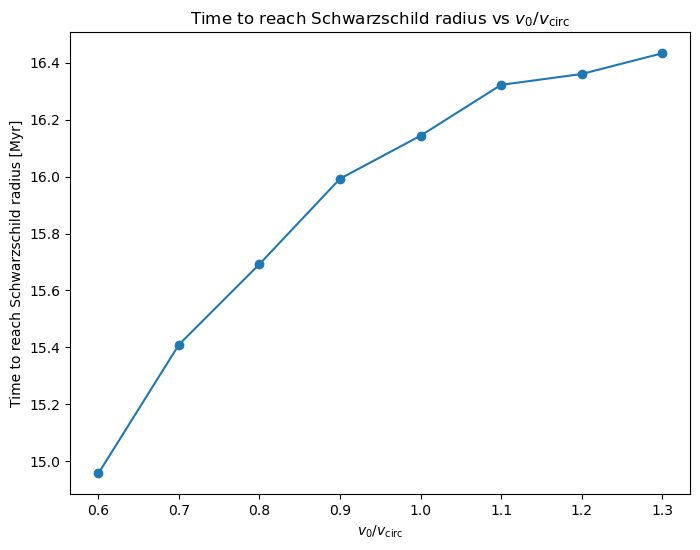

In [39]:
#now we plot the time to reach scahwarszchild radius vs the velocity initial
# Convert and sort arrays
v_init_array = np.array(v_init_list)
time_array = np.array(t_final_list) * 1.45876

# Plot with markers and lines
plt.figure(figsize=(8,6))
plt.plot(v_init_array / v_circ, time_array, marker='o', linestyle='-', linewidth=1.5)
# Labels and title
plt.xlabel('$v_0 / v_{\\rm circ}$')
plt.ylabel('Time to reach Schwarzschild radius [Myr]')
plt.title('Time to reach Schwarzschild radius vs $v_0 / v_{\\rm circ}$')
#plt.grid(True, linestyle='--', alpha=0.6)
plt.show()  

In [ ]:
# -----------------------------
# PARAMETERS
G = 1.0
M_BH = 1.0
r_per = 1e-7  # Target pericenter

# -----------------------------
# INITIAL CONDITIONS
r0 = np.array([1.0, 0.0])
v_circ = np.sqrt(G * M_BH / 4)
v0 = np.array([0.0, 0.8 * v_circ])  # fixed velocity

# Define lists of A and B values to explore
A_values = [5,7] 
B_values = np.linspace(0.5, 10.0, 6) 

# -----------------------------
# INTEGRATION PARAMETERS
t0 = 0.0
dt = 1e-8
delta = 1e-7
min_dt = 1e-18
max_steps = int(1e7)

# -----------------------------
# Arrays to store results
r_hist_list = []
v_hist_list = []
t_hist_list = []
r_final_list = []
t_final_list = []
steps_list = []
AB_list = []

# -----------------------------
# LOOP OVER DIFFERENT A, B VALUES
for A in A_values:
    for B in B_values:
        print(f"\nRunning simulation with A = {A:.2f}, B = {B:.2f}")
        
        r_hist, v_hist, t_hist, t_fin, step = orbits(
            A, B, v0, r_per, max_steps, min_dt, delta, G, M_BH, r0, dt, t0
        )

        # Store results
        r_hist_list.append(r_hist)
        v_hist_list.append(v_hist)
        t_hist_list.append(t_hist)
        r_final_list.append(np.linalg.norm(r_hist[-2]))
        t_final_list.append(t_fin)
        steps_list.append(step)
        AB_list.append((A, B))

        print(f"  → Stopped at t = {t_fin:.3e}, r = {np.linalg.norm(r_hist[-2]):.3e}, steps = {step}")



Running simulation with A = 5.00, B = 0.50
  → Stopped at t = 1.377e+01, r = 1.010e-07, steps = 1205

Running simulation with A = 5.00, B = 2.40
  → Stopped at t = 4.119e+00, r = 1.007e-07, steps = 1018

Running simulation with A = 5.00, B = 4.30
  → Stopped at t = 7.942e+00, r = 1.001e-07, steps = 37953

Running simulation with A = 5.00, B = 6.20
  → Stopped at t = 1.225e+01, r = 1.000e-07, steps = 127228

Running simulation with A = 5.00, B = 8.10
  → Stopped at t = 1.649e+01, r = 1.000e-07, steps = 260111

Running simulation with A = 5.00, B = 10.00
  → Stopped at t = 2.074e+01, r = 1.000e-07, steps = 438548

Running simulation with A = 7.00, B = 0.50
  → Stopped at t = 1.900e+01, r = 1.013e-07, steps = 1409

Running simulation with A = 7.00, B = 2.40
  → Stopped at t = 4.993e+00, r = 1.003e-07, steps = 1029

Running simulation with A = 7.00, B = 4.30
  → Stopped at t = 5.084e+00, r = 1.012e-07, steps = 7161

Running simulation with A = 7.00, B = 6.20
  → Stopped at t = 8.096e+00, 

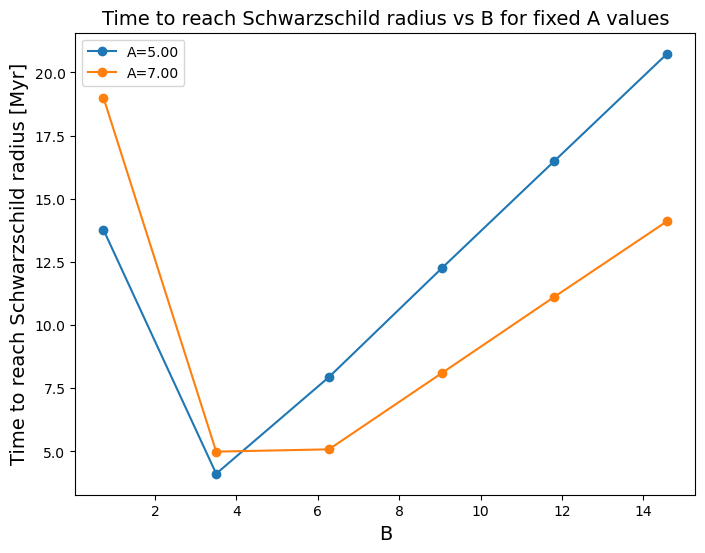

In [ ]:
# -----------------------------
plt.figure(figsize=(8,6))
for A in A_values:
    t_for_A = [t_final_list[i] for i, (a,b) in enumerate(AB_list) if a==A]
    B_for_A = [b * 1.45876 for (a,b) in AB_list if a==A]  #convert to Myr by multiplying 
    plt.plot(B_for_A, t_for_A, marker='o', linestyle='-', label=f'A={A:.2f}')

plt.xlabel('B', fontsize=14)
plt.ylabel('Time to reach Schwarzschild radius [Myr]', fontsize=14)
plt.title('Time to reach Schwarzschild radius vs B for fixed A values',fontsize=14)
plt.legend()
#plt.grid(True, linestyle='--', <alpha=0.6)
plt.show()


In [42]:
# -----------------------------
# PARAMETERS
G = 1.0
M_BH = 1.0
r_per = 1e-7  # Target pericenter

# -----------------------------
# INITIAL CONDITIONS
r0 = np.array([1.0, 0.0])
v_circ = np.sqrt(G * M_BH / 4)
v0 = np.array([0.0, 0.8 * v_circ])  # fixed velocity

# -----------------------------
AB_list = [
    (0.5, 1.0),
    (1.0, 4.0),
    (1.5, 0.8),
    (2.0, 5.0),
    (1.0, 8.0),
    (4.0, 7.0),
    (5.0, 0.5),
    (6.0, 8.0),
    (8.0, 1.0),
    (10.0, 9.0)
]

# -----------------------------
# INTEGRATION PARAMETERS
t0 = 0.0
dt = 1e-8
delta = 1e-7
min_dt = 1e-18
max_steps = int(1e7)

# -----------------------------
# ARRAYS TO STORE RESULTS
r_hist_list = []
v_hist_list = []
t_hist_list = []
r_final_list = []
t_final_list = []
steps_list = []
BA_ratio_list = []

# -----------------------------
# LOOP OVER (A,B) PAIRS
for A, B in AB_list:
    BA = B / A
    print(f"Running simulation with A={A:.2f}, B={B:.2f} (B/A={BA:.2f})")
    
    r_hist, v_hist, t_hist, t_fin, step = orbits(
        A, B, v0, r_per, max_steps, min_dt, delta, G, M_BH, r0, dt, t0
    )
    
    # Store results
    r_hist_list.append(r_hist)
    v_hist_list.append(v_hist)
    t_hist_list.append(t_hist)
    r_final_list.append(np.linalg.norm(r_hist[-2]))
    t_final_list.append(t_fin)
    steps_list.append(step)
    BA_ratio_list.append(BA)
    
    print(f"  → Stopped at t={t_fin:.3e}, r={np.linalg.norm(r_hist[-2]):.3e}, steps={step}")


Running simulation with A=0.50, B=1.00 (B/A=2.00)
  → Stopped at t=2.422e+01, r=1.000e-07, steps=107763
Running simulation with A=1.00, B=4.00 (B/A=4.00)
  → Stopped at t=4.725e+01, r=1.001e-07, steps=712053
Running simulation with A=1.50, B=0.80 (B/A=0.53)
  → Stopped at t=4.548e+00, r=1.010e-07, steps=2301
Running simulation with A=2.00, B=5.00 (B/A=2.50)
  → Stopped at t=2.767e+01, r=1.001e-07, steps=403709
Running simulation with A=1.00, B=8.00 (B/A=8.00)
  → Stopped at t=9.786e+01, r=1.000e-07, steps=3233495
Running simulation with A=4.00, B=7.00 (B/A=1.75)
  → Stopped at t=1.817e+01, r=1.002e-07, steps=275119
Running simulation with A=5.00, B=0.50 (B/A=0.10)
  → Stopped at t=1.377e+01, r=1.010e-07, steps=1205
Running simulation with A=6.00, B=8.00 (B/A=1.33)
  → Stopped at t=1.316e+01, r=1.002e-07, steps=173576
Running simulation with A=8.00, B=1.00 (B/A=0.12)
  → Stopped at t=1.121e+01, r=1.006e-07, steps=1104
Running simulation with A=10.00, B=9.00 (B/A=0.90)
  → Stopped at t=8

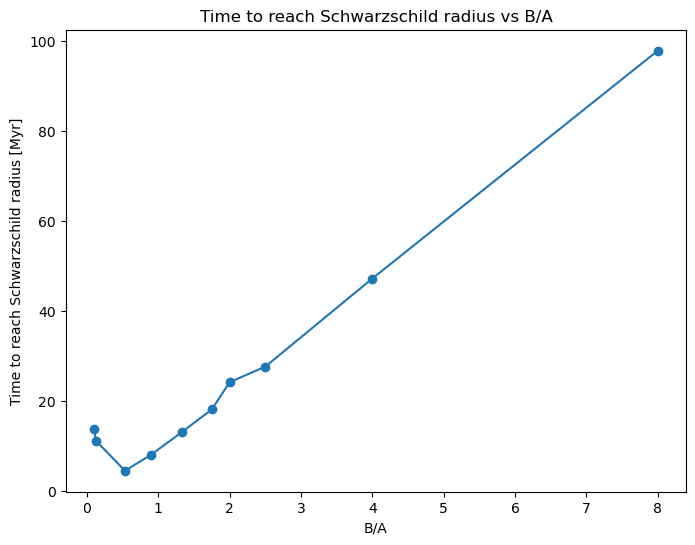

In [43]:
# -----------------------------
# -----------------------------
# Sort arrays by B/A ratio
t_final_listMyr = np.array(t_final_list) * 1.45876  # Convert to Myr
BA_sorted, t_sorted = zip(*sorted(zip(BA_ratio_list, t_final_list)))

# -----------------------------
# Plot: time to reach Schwarzschild radius vs B/A
plt.figure(figsize=(8,6))
plt.plot(BA_sorted, t_sorted , marker='o', linestyle='-')
plt.xlabel('B/A')
plt.ylabel('Time to reach Schwarzschild radius [Myr]')
plt.title('Time to reach Schwarzschild radius vs B/A')
#plt.grid(True, linestyle='--', alpha=0.6)
plt.show()